# Бинарная классификация: Имеется ли Bounding Box

Для чего нотубук:
* Построить бейзлайн по модели "Имеется ли Bounding Box"

`Note`: оказался самый сложный кейс, тяжелее чем multi class

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns

np.random.seed(21)
random_state = 147

DATA_FOLDER = "data/"

In [2]:
df_images = pd.read_csv(DATA_FOLDER + "data_DEC24_SVD_128comp_5000.csv").iloc[:, 1:]

df_images["class"] = np.where(df_images["class"] == 0, 1, 0)

In [3]:
print("1 - has bb \n0 - not has bb\n")

print(df_images.shape)
df_images.head(4)

1 - has bb 
0 - not has bb

(5000, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,class
0,-1297,-4191,4968,13525,23092,2697,6673,-6180,-7511,3308,...,-1621,-333,625,-981,208,-1723,-1369,622,1078,0
1,17405,5688,-8329,-8232,2108,6171,822,1740,1672,1781,...,2242,-2151,-298,-1812,71,303,427,-322,866,0
2,-8478,-25664,-19107,-18964,491,-12445,395,2966,719,3463,...,30,-44,-468,290,-119,-984,44,-989,378,0
3,13479,-25028,12294,6340,2088,11904,-1974,2324,-3662,1154,...,-301,1070,-435,37,-506,-1057,-1564,-861,1274,0


## Split Data

In [4]:
X, y = df_images.drop(columns="class"), df_images["class"]

In [5]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

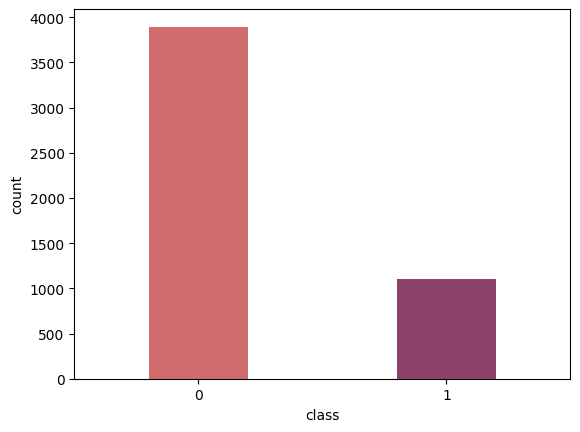

In [6]:
sns.countplot(x=y, hue=y, legend=False, palette='flare', width=0.4);

In [7]:
from sklearn.metrics import f1_score

def get_fast_metrics(y_pred, y_true, ) -> None:

    f1 = np.round(f1_score(y_pred, y_true, average="weighted"), 8)
    freq = np.round(np.sum(y_true == 0)/y_true.shape[0], 8)
    win_norm = np.round((f1 - freq) / (1 - freq), 8)

    print(f"F1-score: {f1}")
    print(f"Freq class: {freq}")
    print(f"Win-norm: {win_norm}")


## Models

`Note`: Очень долго не могли получить приличные метрики только линейными решениями. Потом предобработали данные + использовали не линейные ядра, получилось. Потом добавили ещё хорошо предобработанных данных, и получилось с линейными моделями.

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [9]:
scl = MinMaxScaler().fit(X_train)

X_train = scl.transform(X_train)
X_test = scl.transform(X_test)

### Попробуем Linear SVM

In [10]:
Linear_SVM = SVC(kernel="linear", random_state=random_state)
Linear_SVM.fit(X_train, y_train)

y_pred = Linear_SVM.predict(X_test)
get_fast_metrics(y_pred, y_test)

F1-score: 0.83607469
Freq class: 0.781
Win-norm: 0.2514826


Отлично, уже Win-norm положительна. Цель достигнута. Но, хотим модель лучше.

## Non Linear SVM

In [11]:
NonLinear_SVM = SVC(kernel="rbf", random_state=random_state)
NonLinear_SVM.fit(X_train, y_train)

y_pred = NonLinear_SVM.predict(X_test)
get_fast_metrics(y_pred, y_test)

F1-score: 0.8357586
Freq class: 0.781
Win-norm: 0.25003927


Хотим модель ещё лучше.

## NonLinearSVM + GridSearch

Поскольку мы сократили признаковое пространство до 128 переменных, мы может порадовать себя GridSearchCV.

Будем переберать параметры постепенно.

In [12]:
params = {
    "kernel": ["rbf", "sigmoid", "poly"],  #  default='rbf'
    "decision_function_shape" : ["ovo", "ovr"],  # default='ovo'
    "gamma" : ["auto", "scale"]  # default='scale'
}

cv = GridSearchCV(
    SVC(random_state=random_state, max_iter=-1, tol=1e-3), 
    param_grid=params
)

cv.fit(X_train, y_train)
cv.best_params_

{'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf'}

Лучшие параметры - это буквально значения по умолчанию.

In [13]:
params = {
    "tol" : [1e-2, 1e-2/2, 1e-3, 1e-3/2, 1e-4]
}

cv = GridSearchCV(
    SVC(random_state=random_state, max_iter=-1), 
    param_grid=params
)

cv.fit(X_train, y_train)
cv.best_params_

{'tol': 0.01}

In [ ]:
params = {
    "tol" : [0.001, 0.005, 0.01],
    "C" : [0.5, 1.0, 1.5, 2, 2.5, 3, 3.5],
}

cv = GridSearchCV(
    SVC(random_state=random_state, max_iter=-1), 
    param_grid=params
)

cv.fit(X_train, y_train)
cv.best_params_

{'C': 1.5, 'tol': 0.001}

In [22]:
NonLinear_SVM_cv = cv.best_estimator_

y_pred = NonLinear_SVM_cv.predict(X_test)
get_fast_metrics(y_pred, y_test)

F1-score: 0.82817362
Freq class: 0.781
Win-norm: 0.21540466


## Метрики

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

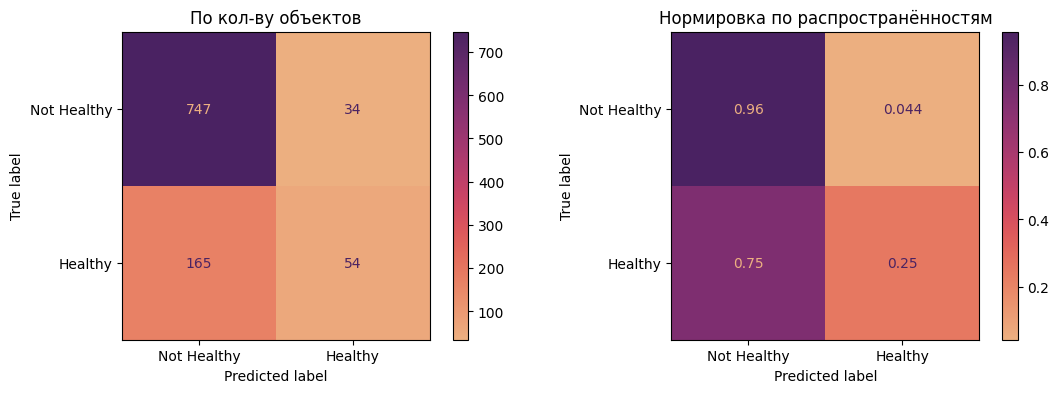

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))

labels = ["Not Healthy", "Healthy"]
ax[0].set_title("По кол-ву объектов")
ax[1].set_title("Нормировка по распространённостям")

ConfusionMatrixDisplay.from_estimator(NonLinear_SVM, X_test, y_test, display_labels=labels, cmap="flare", ax=ax[0]);
ConfusionMatrixDisplay.from_estimator(NonLinear_SVM, X_test, y_test, display_labels=labels, cmap="flare", normalize="true", ax=ax[1]);

In [25]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay, DetCurveDisplay

classifiers = [("Linear_SVM", Linear_SVM), ("NonLinear_SVM", NonLinear_SVM), ("NonLinear_SVM_cv", NonLinear_SVM_cv)]

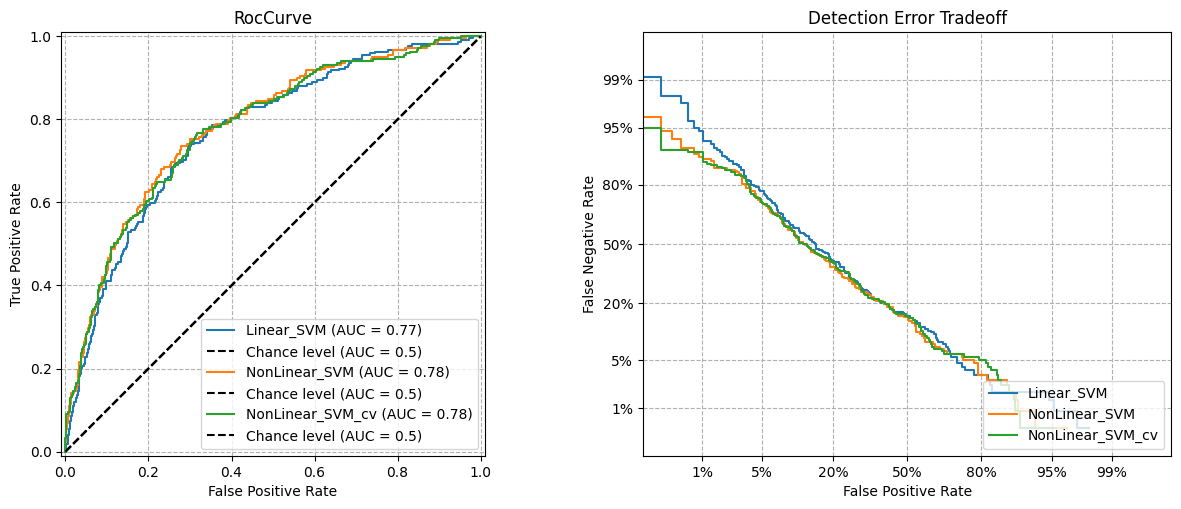

In [ ]:
fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(15, 5.5))

for name, clf in classifiers:

    display = RocCurveDisplay.from_estimator(clf, X_test, y_test, plot_chance_level=True, ax=ax_roc, name=name)
    _ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="RocCurve",
    )

    display = DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)
    _ = display.ax_.set(
        title="Detection Error Tradeoff",
        xlabel="False Positive Rate",
        ylabel="False Negative Rate",
    )


ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")


In [27]:
for name, clf in classifiers:
    print(name)
    roc_auc_metric = roc_auc_score(clf.predict(X_test), y_test)
    gini = 2 * roc_auc_metric - 1
    print("roc_auc: ", np.round(roc_auc_metric, 8))
    print("gini: ", np.round(gini, 8))
    print("")

Linear_SVM
roc_auc:  0.69293046
gini:  0.38586091

NonLinear_SVM
roc_auc:  0.71635766
gini:  0.43271531

NonLinear_SVM_cv
roc_auc:  0.70941289
gini:  0.41882578

